In [1]:
import pandas as pd
import datetime
import random
import os

from bokeh.plotting import figure
from bokeh.palettes import Category20
from bokeh.layouts import gridplot
from bokeh.io import output_notebook, show

output_notebook()

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

palette = Category20[20]

os.chdir("/".join(os.getcwd().split("/")[0:-1]))
print("working dir", os.getcwd())

from src.dao.dbdao import DBDAO
from src.dao import csv_dao
from src.plot import plot
from src.utils import geo
from src.utils.time_utils import diff_between_dates


# from sklearn.cluster import KMeans

import gc

pd.set_option('display.float_format', lambda x: '%.3f' % x)

Loading BokehJS ...

working dir /home/tales/dev/master/mdc_analysis


In [2]:
def load_user_stop_regions(userid, verbose=True):
    stop_regions = csv_dao.load_user_stop_regions(userid)
    if verbose:
        print("{} stop regions loaded".format(len(stop_regions)))
        counter = 0
        for sr in stop_regions:
            counter += len(sr)
        print("{} points loaded".format(counter))
    return stop_regions

def stop_region_centroid(stop_region):
    return geo.cluster_centroid(stop_region)
    
def pick_random_user():
    return pd.Series(DBDAO().users()).sample().iloc[0][0]

# Stop Regions

In [3]:
centroids = csv_dao.load_all_users_stop_regions_centroids(verbose=True)

User 6189 data loaded
User 5936 data loaded
User 6087 data loaded
User 5973 data loaded
User 6085 data loaded
User 6074 data loaded
User 6012 data loaded
User 5982 data loaded
User 5948 data loaded
User 5974 data loaded
User 6090 data loaded
User 6199 data loaded
User 6068 data loaded
User 6024 data loaded
User 5976 data loaded
User 6094 data loaded
User 5941 data loaded
User 5995 data loaded
User 5962 data loaded
User 6093 data loaded
User 6033 data loaded
User 6079 data loaded
User 6038 data loaded
User 6175 data loaded
User 6042 data loaded
User 5924 data loaded
User 6083 data loaded
User 6178 data loaded
User 5958 data loaded
User 6086 data loaded
User 6100 data loaded
User 5945 data loaded
User 5925 data loaded
User 5935 data loaded
User 6172 data loaded
User 5955 data loaded
User 6073 data loaded
User 5980 data loaded
User 6010 data loaded
User 5993 data loaded
User 6037 data loaded
User 5979 data loaded
User 5966 data loaded
User 5985 data loaded
User 5967 data loaded
User 5970 

In [4]:
home_and_work_centroids = centroids[(centroids["tag"] == 'HOME') | (centroids["tag"] == 'WORK')]
other_centroids = centroids[centroids["tag"] == '']

Removing duplicated centroids (with same center location)

In [5]:
home_and_work_centroids = csv_dao.unique_stop_regions(home_and_work_centroids)
other_centroids = csv_dao.unique_stop_regions(other_centroids)
unique_centroids = other_centroids.append(home_and_work_centroids)

In [6]:
unique_centroids.sample(8)

,latitude,local_end_time,local_start_time,longitude,sr_id,tag,user_id
2652,46.575,1275777353.000,1275776521.000,6.840,6177_573,HOME,6177
14,46.633,1256213310.000,1256212261.000,7.049,5975_110,,5975
277,46.201,1288196081.000,1288194905.000,6.041,6179_348,,6179
1383,46.509,1291344034.000,1291343479.000,6.668,6177_2242,,6177
186,46.527,1277572975.000,1277571627.000,6.567,5980_266,,5980
25,46.040,1263627949.000,1263625860.000,7.270,6043_120,,6043
225,46.457,1286709911.000,1286709572.000,6.966,6192_300,,6192
695,46.184,1269855096.000,1269854787.000,6.830,6004_483,,6004


### Tags (Home, Work, Other)

In [7]:
values = unique_centroids['tag'].value_counts()
print(values)
print()
print("{0:.2f}% are tagged as HOME OR WORK".format(100 * (values["HOME"] + values["WORK"]) / values.sum()))
print("{} stop regions have no tag".format(values['']))

        44944
HOME    16312
WORK     6068
Name: tag, dtype: int64

33.24% are tagged as HOME OR WORK
44944 stop regions have no tag


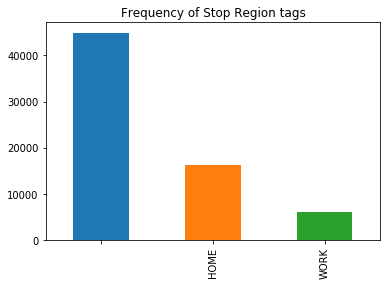

In [8]:
unique_centroids['tag'].value_counts().plot.bar(title="Frequency of Stop Region tags")

### Time difference between curent and next centroid

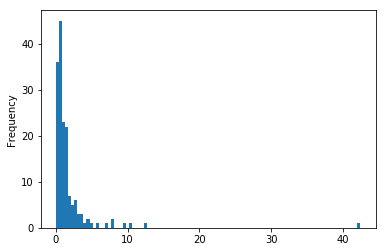

In [9]:
user_sr_time = []
for user_id in unique_centroids["user_id"].drop_duplicates().tolist():
    user_sr = unique_centroids[unique_centroids["user_id"] == user_id]
    delta_t = diff_between_dates(user_sr["local_start_time"].min(), user_sr["local_end_time"].max())
    
    user_sr_time.append({"user_id": user_id, "delta_t": delta_t, "n_stop_regions": len(user_sr)})
    
user_sr_time = pd.DataFrame(user_sr_time)
user_sr_time["sr_per_day"] = user_sr_time["n_stop_regions"] / user_sr_time["delta_t"]
user_sr_time["sr_per_day"].plot.hist(bins=100)

In [10]:
user_sr_time["sr_per_day"].describe()

count   162.000
mean      1.726
std       3.714
min       0.033
25%       0.505
50%       0.888
75%       1.600
max      42.421
Name: sr_per_day, dtype: float64